# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Thọ Tài
- MSSV: 23127255
- Lớp: 23CLC02

## Import các thư viện liên quan

In [77]:
!python -m pip install matplotlib
!python -m pip install numpy
!python -m pip install Pillow
from matplotlib import pyplot as plt
import numpy as np
import tracemalloc

## Helper functions

In [78]:
from PIL import Image

def read_img(img_path: str):
	"""
	Read image from img_path

	Parameters
	----------
	img_path : str
		Path of image

	Returns
	-------
		Image (2D)
	"""
	return Image.open(img_path)

def show_img(img_2d: Image):
	"""
	Show image

	Parameters
	----------
	img_2d:
		Image (2D)
	"""
	plt.imshow(img_2d)
	plt.axis('off')
	plt.show()


def save_img(img_2d: Image, img_path: str):
	"""
	Save image to img_path

	Parameters
	----------
	img_2d:
		Image (2D)
	img_path : str
		Path of image
	"""
	img_2d.save(img_path)


def convert_img_to_1d(img_2d: Image):
	"""
	Convert 2D image to 1D image

	Parameters
	----------
	img_2d: <your type>
		Image (2D)

	Returns
	-------
		Image (1D)
	"""
	img_np = np.array(img_2d)
	return img_np.reshape(-1, 3)


def kmeans(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random') -> tuple[np.ndarray, np.ndarray]:
	"""
	K-Means algorithm

	Parameters
	----------
	img_1d: np.ndarray with shape=(height * width, num_channels)
		Original (1D) image
	k_clusters : int
		Number of clusters
	max_iter : int
		Max iterator
	init_centroids : str, default='random'
		The method used to initialize the centroids for K-means clustering
		'random' --> Centroids are initialized with random values between 0 and 255 for each channel
		'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

	Returns
	-------
	centroids : np.ndarray with shape=(k_clusters, num_channels)
		Stores the color centroids for each cluster
	labels : np.ndarray with shape=(height * width, )
		Stores the cluster label for each pixel in the image
	"""
	n_pixels, n_channels = img_1d.shape

	centroids: np.ndarray
	match init_centroids:
		case 'random':
			centroids = np.random.uniform(0, 255, size=(k_clusters, n_channels)).astype(np.float32)
		case 'in_pixels':
			indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
			centroids = img_1d[indices].astype(np.float32)
		case _:
			raise ValueError("Invalid init_centroids value")

	labels = np.zeros(n_pixels, dtype=np.int32)

	for _ in range(max_iter):
		diff = img_1d[:, None, :] - centroids[None, :, :] # get subtraction result
		distances = np.sum(diff * diff, axis=2)
		new_labels = np.argmin(distances, axis=1)

		# early stopping if labels don't change
		if np.all(new_labels == labels):
			break
		labels = new_labels

		counts = np.bincount(labels, minlength=k_clusters) # count the number of pixels inside a cluster
		sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
		np.add.at(sums, labels, img_1d)
		valid = counts > 0
		old_centroids = centroids[valid].copy()
		centroids[valid] = sums[valid] / counts[valid][:, None]
		if np.sum((centroids[valid] - old_centroids) ** 2) < 1e-6:
			break

	return centroids.astype(np.uint8), labels

def kmeans2(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random') -> tuple[np.ndarray, np.ndarray]:

	n_pixels, n_channels = img_1d.shape

	centroids: np.ndarray
	match init_centroids:
		case 'random':
			centroids = np.random.uniform(0, 255, size=(k_clusters, n_channels)).astype(np.float32)
		case 'in_pixels':
			indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
			centroids = img_1d[indices].astype(np.float32)
		case _:
			raise ValueError("Invalid init_centroids value")

	labels = np.zeros(n_pixels, dtype=np.int32)

	for _ in range(max_iter):
		distances = np.sum((img_1d[:, None, :] - centroids[None, :, :]) ** 2, axis=2)
		new_labels = np.argmin(distances, axis=1)

		if np.all(new_labels == labels):
			break
		labels = new_labels

		counts = np.bincount(labels, minlength=k_clusters) # count the number of pixels inside a cluster
		sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
		np.add.at(sums, labels, img_1d)
		valid = counts > 0
		old_centroids = centroids[valid].copy()
		centroids[valid] = sums[valid] / counts[valid][:, None]
		if np.all(np.abs(centroids[valid] - old_centroids) < 1e-6):
			break

	return centroids.astype(np.uint8), labels

def generate_2d_img(img_2d_shape, centroids, labels):
	"""
	Generate a 2D image based on K-means cluster centroids

	Parameters
	----------
	img_2d_shape : tuple (height, width, 3)
		Shape of image
	centroids : np.ndarray with shape=(k_clusters, num_channels)
		Store color centroids
	labels : np.ndarray with shape=(height * width, )
		Store label for pixels (cluster's index on which the pixel belongs)

	Returns
	-------
		New image (2D)
	"""

	height, width, channels = img_2d_shape
	clusters = centroids[labels]
	return Image.fromarray(clusters.reshape((height, width, channels)).astype(np.uint8))

def count_color(img: Image) -> int:
	img_1d = convert_img_to_1d(img)
	return np.unique(img_1d, axis=0).shape[0]

## Your tests

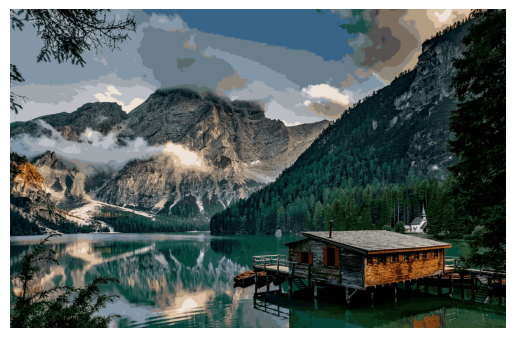

Current memory usage: 43.86 MB
Peak memory usage: 2933.53 MB


In [79]:
tracemalloc.start()
img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans(img_1d, k_clusters=29, max_iter=25, init_centroids='in_pixels')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed1.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")


## Main FUNCTION

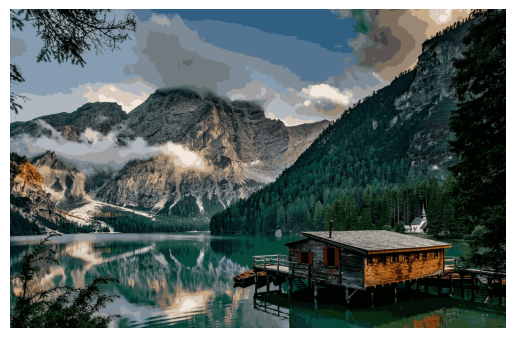

Current memory usage: 43.86 MB
Peak memory usage: 2572.65 MB


In [80]:
tracemalloc.start()
img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans2(img_1d, k_clusters=29, max_iter=25, init_centroids='in_pixels')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed2.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

In [81]:
!python -m pip install scikit-learn
from sklearn.cluster import KMeans

def kmeans_sklearn(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random'):
    kmeans = KMeans(n_clusters=k_clusters, max_iter=max_iter, init=init_centroids, n_init=1)
    labels = kmeans.fit_predict(img_1d)
    centroids = kmeans.cluster_centers_
    return centroids.astype(np.uint8), labels


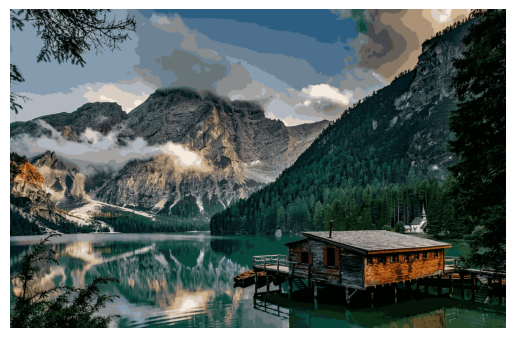

Current memory usage: 31.42 MB
Peak memory usage: 507.08 MB


In [82]:
tracemalloc.start()

img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans_sklearn(img_1d, k_clusters=29, max_iter=25, init_centroids='k-means++')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed_sklearn.jpg')

current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

In [83]:
def kmeans3(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random') -> tuple[np.ndarray, np.ndarray]:
	n_pixels, n_channels = img_1d.shape
	img_1d = img_1d.astype(np.float32)
	centroids = np.empty((k_clusters, n_channels), dtype=np.float32)
	match init_centroids:
		case 'random':
			centroids[:] = np.random.uniform(0, 255, size=(k_clusters, n_channels)).astype(np.float32)
		case 'in_pixels':
			indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
			centroids[:] = img_1d[indices].astype(np.float32)
		case _:
			raise ValueError("Invalid init_centroids value")

	labels = np.zeros(n_pixels, dtype=np.int32)
	img_sq = np.sum(img_1d ** 2, axis=1)[:, None] # precompute ||x||^2

	for _ in range(max_iter):
		# compute distances without creating a bigger matrix: ||x - c||^2 = ||x||^2 + ||c||^2 - 2*x*c
		cent_sq = np.sum(centroids ** 2, axis=1)[None, :] # ||c||^2
		dot_product = img_1d @ centroids.T  # numpy matrix multiplication x * c
		distances_sq = img_sq + cent_sq - 2 * dot_product
		new_labels = np.argmin(distances_sq, axis=1)
		if np.array_equal(new_labels, labels):
			break
		# Update centroids
		counts = np.bincount(new_labels, minlength=k_clusters)
		sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
		np.add.at(sums, new_labels, img_1d)
		valid = counts > 0
		new_centroids = np.where(valid[:, None], sums / np.maximum(counts[:, None], 1), centroids)

		# check convergence based on centroids
		if np.all(np.abs(new_centroids[valid] - centroids[valid]) < 1e-5):
			break

		centroids[:] = new_centroids
		labels[:] = new_labels

	return centroids.astype(np.uint8), labels

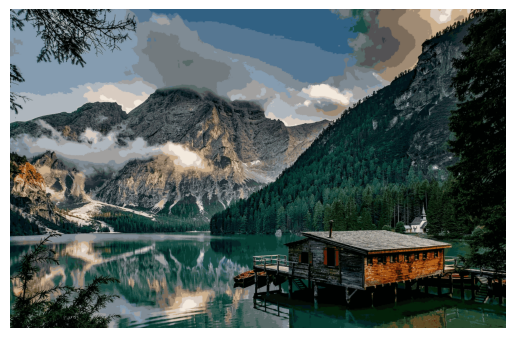

Current memory usage: 31.42 MB
Peak memory usage: 1913.16 MB


In [84]:
tracemalloc.start()

img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans3(img_1d, k_clusters=29, max_iter=25, init_centroids='in_pixels')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed3.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

In [85]:
def kmeans4(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random') -> tuple[np.ndarray, np.ndarray]:
	n_pixels, n_channels = img_1d.shape
	img_1d = img_1d.astype(np.float32)
	centroids = np.empty((k_clusters, n_channels), dtype=np.float32)
	match init_centroids:
		case 'random':
			centroids[:] = np.random.uniform(0, 255, size=(k_clusters, n_channels)).astype(np.float32)
		case 'in_pixels':
			indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
			centroids[:] = img_1d[indices].astype(np.float32)
		case _:
			raise ValueError("Invalid init_centroids value")

	labels = np.zeros(n_pixels, dtype=np.int32)
	img_sq = np.sum(img_1d ** 2, axis=1)[:, None]
	distances_sq = np.empty((n_pixels, k_clusters), dtype=np.float32)
	for _ in range(max_iter):
		cent_sq = np.sum(centroids ** 2, axis=1)[None, :] # ||c||^2
		dot_product = img_1d @ centroids.T  # numpy matrix multiplication x * c
		distances_sq[:] = img_sq + cent_sq - 2 * dot_product
		labels[:] = np.argmin(distances_sq, axis=1)

		# Update centroids
		counts = np.bincount(labels, minlength=k_clusters)
		sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
		np.add.at(sums, labels, img_1d)
		valid = counts > 0
		new_centroids = np.where(valid[:, None], sums / np.maximum(counts[:, None], 1), centroids)

		# check convergence based on centroids
		if np.all(np.abs(new_centroids[valid] - centroids[valid]) < 1e-5):
			break

		centroids[:] = new_centroids

	return centroids.astype(np.uint8), labels

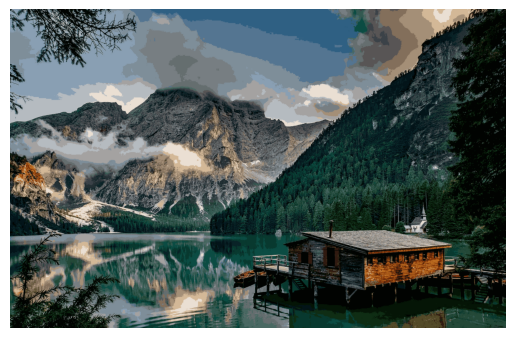

Current memory usage: 31.41 MB
Peak memory usage: 1888.27 MB


In [86]:
tracemalloc.start()

img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans4(img_1d, k_clusters=29, max_iter=25, init_centroids='in_pixels')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed4.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

In [87]:
def kmeans5(img_1d: np.ndarray, k_clusters: int, max_iter: int,
                    init_centroids: str = 'kmeans++') -> tuple[np.ndarray, np.ndarray]:
    """
    Optimized K-means clustering for image data using only NumPy.

    Args:
        img_1d: Input image as 1D array (n_pixels, n_channels)
        k_clusters: Number of clusters
        max_iter: Maximum iterations
        init_centroids: Initialization method ('random', 'in_pixels', 'kmeans++')

    Returns:
        tuple: (centroids, labels)
    """
    n_pixels, n_channels = img_1d.shape
    img_1d = img_1d.astype(np.float32, copy=False)
    centroids = np.zeros((k_clusters, n_channels), dtype=np.float32)

    # Centroid initialization
    if init_centroids == 'kmeans++':
        # K-means++ initialization using NumPy only
        idx = np.random.randint(0, n_pixels)
        centroids[0] = img_1d[idx]

        dists = np.full(n_pixels, np.inf, dtype=np.float32)
        for i in range(1, k_clusters):
            # Compute squared distances to nearest centroid
            diff = img_1d - centroids[i-1]
            new_dists = np.sum(diff * diff, axis=1)
            dists = np.minimum(dists, new_dists)

            # Choose the next centroid with probability proportional to distance
            probs = dists / dists.sum()
            idx = np.random.choice(n_pixels, p=probs)
            centroids[i] = img_1d[idx]

    elif init_centroids == 'random':
        centroids[:] = np.random.uniform(0, 255, size=(k_clusters, n_channels))

    elif init_centroids == 'in_pixels':
        indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
        centroids[:] = img_1d[indices]

    else:
        raise ValueError("Invalid init_centroids value")

    labels = np.zeros(n_pixels, dtype=np.int32)
    img_sq = np.sum(img_1d ** 2, axis=1)[:, None]  # Precompute ||x||^2

    for _ in range(max_iter):
        # Compute distances: ||x - c||^2 = ||x||^2 + ||c||^2 - 2*x*c
        cent_sq = np.sum(centroids ** 2, axis=1)[None, :]  # ||c||^2
        dot_product = img_1d @ centroids.T
        distances_sq = img_sq + cent_sq - 2 * dot_product

        new_labels = np.argmin(distances_sq, axis=1)

        # Check for label convergence
        if np.all(new_labels == labels):
            break

        labels[:] = new_labels

        # Update centroids
        sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
        counts = np.bincount(new_labels, minlength=k_clusters)
        np.add.at(sums, new_labels, img_1d)

        # only update valid centroids (avoid division by zero)
        valid = counts > 0
        centroids[valid] = sums[valid] / counts[valid][:, None]

        # Check centroid convergence
        if np.all(np.abs(centroids[valid] - sums[valid] / counts[valid][:, None]) < 1e-5):
            break

    return centroids.astype(np.uint8), labels

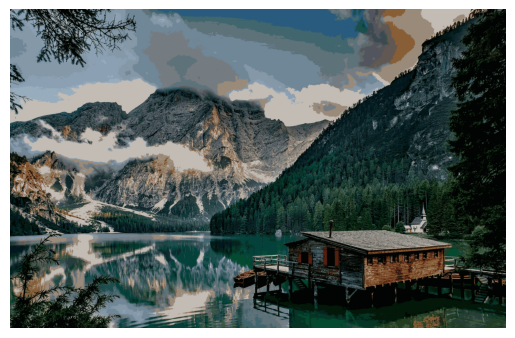

Current memory usage: 31.41 MB
Peak memory usage: 1527.42 MB


In [88]:
tracemalloc.start()

img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans5(img_1d, k_clusters=29, max_iter=25, init_centroids='in_pixels')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed5.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

In [89]:
def kmeans6(img_1d: np.ndarray, k_clusters: int, max_iter: int, init_centroids: str = 'random', batch_size: int = 10000) -> tuple[np.ndarray, np.ndarray]: # optimized kmean3
    n_pixels, n_channels = img_1d.shape
    img_1d = img_1d.astype(np.float32)
    centroids = np.empty((k_clusters, n_channels), dtype=np.float32)

    # Initialize centroids
    match init_centroids:
        case 'random':
            centroids[:] = np.random.uniform(0, 255, size=(k_clusters, n_channels)).astype(np.float32)
        case 'in_pixels':
            indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
            centroids[:] = img_1d[indices].astype(np.float32)
        case _:
            raise ValueError("Invalid init_centroids value")

    labels = np.zeros(n_pixels, dtype=np.int32)
    img_sq = np.sum(img_1d ** 2, axis=1)  # (n_pixels,)

    for _ in range(max_iter):
        cent_sq = np.sum(centroids ** 2, axis=1)  # (k_clusters,)
        new_labels = np.zeros(n_pixels, dtype=np.int32)

        # Process in batches
        for start in range(0, n_pixels, batch_size):
            end = min(start + batch_size, n_pixels)
            batch_img = img_1d[start:end]
            batch_img_sq = img_sq[start:end][:, None]  # (batch_size, 1)

            # Compute distances for batch
            dot_product = batch_img @ centroids.T  # (batch_size, k_clusters)
            distances_sq = batch_img_sq + cent_sq[None, :] - 2 * dot_product  # (batch_size, k_clusters)
            new_labels[start:end] = np.argmin(distances_sq, axis=1)

        # Check for convergence
        if np.array_equal(new_labels, labels):
            break

        # Update centroids
        counts = np.bincount(new_labels, minlength=k_clusters)
        sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
        np.add.at(sums, new_labels, img_1d)
        valid = counts > 0
        new_centroids = np.where(valid[:, None], sums / np.maximum(counts[:, None], 1), centroids)

        if np.all(np.abs(new_centroids[valid] - centroids[valid]) < 1e-5):
            break

        centroids[:] = new_centroids
        labels[:] = new_labels

    return centroids.astype(np.uint8), labels

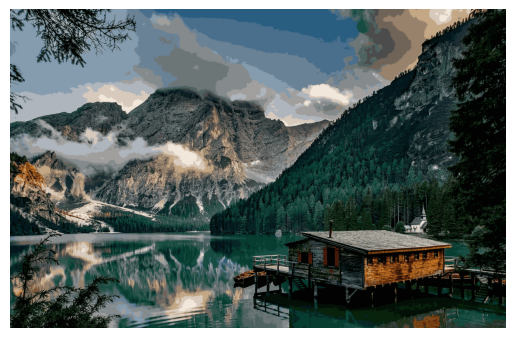

Current memory usage: 31.41 MB
Peak memory usage: 121.52 MB


In [90]:
tracemalloc.start()

img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans6(img_1d, k_clusters=29, max_iter=25, init_centroids='in_pixels')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed6.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

In [91]:
def kmeans5_6(img_1d: np.ndarray, k_clusters: int, max_iter: int,
            init_centroids: str = 'kmeans++', batch_size: int = 10000) -> tuple[np.ndarray, np.ndarray]:
    """
    Optimized K-means clustering for image data using both batch processing and advanced initialization.

    Args:
        img_1d: Input image as 1D array (n_pixels, n_channels)
        k_clusters: Number of clusters
        max_iter: Maximum iterations
        init_centroids: Initialization method ('random', 'in_pixels', 'kmeans++')
        batch_size: Batch size for distance computation.

    Returns:
        tuple: (centroids, labels)
    """
    n_pixels, n_channels = img_1d.shape
    img_1d = img_1d.astype(np.float32, copy=False)
    centroids = np.zeros((k_clusters, n_channels), dtype=np.float32)

    # Centroid initialization
    if init_centroids == 'kmeans++':
        # K-means++ initialization using NumPy only
        idx = np.random.randint(0, n_pixels)
        centroids[0] = img_1d[idx]

        dists = np.full(n_pixels, np.inf, dtype=np.float32)
        for i in range(1, k_clusters):
            # Compute squared distances to nearest centroid
            diff = img_1d - centroids[i-1]
            new_dists = np.sum(diff * diff, axis=1)
            dists = np.minimum(dists, new_dists)

            # Choose the next centroid with probability proportional to distance
            probs = dists / dists.sum()
            idx = np.random.choice(n_pixels, p=probs)
            centroids[i] = img_1d[idx]

    elif init_centroids == 'random':
        centroids[:] = np.random.uniform(0, 255, size=(k_clusters, n_channels))

    elif init_centroids == 'in_pixels':
        indices = np.random.choice(n_pixels, size=k_clusters, replace=False)
        centroids[:] = img_1d[indices]
    else:
        raise ValueError("Invalid init_centroids value")

    labels = np.zeros(n_pixels, dtype=np.int32)
    img_sq = np.sum(img_1d ** 2, axis=1)  # Precompute ||x||^2

    for _ in range(max_iter):
        cent_sq = np.sum(centroids ** 2, axis=1)  # ||c||^2
        new_labels = np.zeros(n_pixels, dtype=np.int32)

        # Process in batches
        for start in range(0, n_pixels, batch_size):
            end = min(start + batch_size, n_pixels)
            batch_img = img_1d[start:end]
            batch_img_sq = img_sq[start:end][:, None]  # (batch_size, 1)

            # Compute distances for batch
            dot_product = batch_img @ centroids.T  # (batch_size, k_clusters)
            distances_sq = batch_img_sq + cent_sq[None, :] - 2 * dot_product  # (batch_size, k_clusters)
            new_labels[start:end] = np.argmin(distances_sq, axis=1)

        # Check for label convergence
        if np.all(new_labels == labels):
            break

        labels[:] = new_labels

        # Update centroids
        sums = np.zeros((k_clusters, n_channels), dtype=np.float32)
        counts = np.bincount(new_labels, minlength=k_clusters)
        np.add.at(sums, new_labels, img_1d)

        # Only update valid centroids (avoid division by zero)
        valid = counts > 0
        centroids[valid] = sums[valid] / counts[valid][:, None]

        # Check centroid convergence
        if np.all(np.abs(centroids[valid] - sums[valid] / counts[valid][:, None]) < 1e-5):
            break

    return centroids.astype(np.uint8), labels

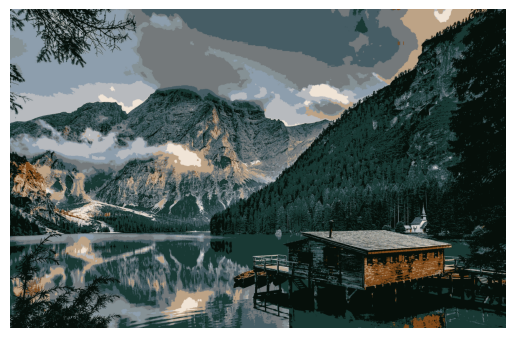

Current memory usage: 144.02 MB
Peak memory usage: 296.23 MB


In [150]:
tracemalloc.start()

img_path = 'example.jpg'
img = read_img(img_path)
img_1d = convert_img_to_1d(img)
img_centroids, img_labels = kmeans5_6(img_1d, k_clusters=10, max_iter=25, init_centroids='kmeans++')
compressed_img = generate_2d_img(np.array(img).shape, img_centroids, img_labels)
show_img(compressed_img)
save_img(compressed_img, 'example_compressed5_6.jpg')
current, peak = tracemalloc.get_traced_memory()  # Get current and peak memory usage
tracemalloc.stop()  # Stop tracing memory

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")